In [1]:
import numpy as np
from skimage.data import camera
import matplotlib.pyplot as plt

x = np.array(camera()).reshape(1, 1, 512, 512)
w = np.concatenate((np.array([[1, 2, 1], 
                              [0, 0, 0],
                              [-1, -2, -1]
                             ]).reshape(1, 1, 3, 3),
                    np.array([[1, 0, -1], 
                              [2, 0, -2],
                              [1, 0, -1]
                             ]).reshape(1, 1, 3, 3)))

(1, 1, 512, 512)


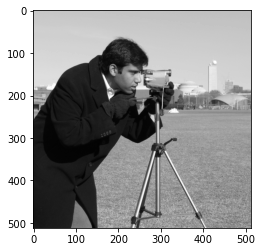

In [2]:
print (np.shape(x))
plt.imshow(x.squeeze(), cmap='gray')

In [3]:
# What is N, Cin, H and W for image?
# Answer: 
# N = 1, C_in = 1, H = 512, W = 512 
# img number, number of channels (3 rgb, 1 gray), height, width

In [4]:
np.shape(w)

(2, 1, 3, 3)

In [5]:
# What is Cout, Cin, FH and FW in this case?
# Answer:
# C_out = 2, C_in = 1, FH = 3, FW = 3
# number of filters (numberr of output channels after filter apply), 
# number of input channels before filter apply?, 
# filter height, filter width

In [6]:
# If we assume a stride of 1, how must the image x be zero-padded so that the filtered image will have the
# same spatial resolution as the original image?

In [7]:
# (W – F + 2P) / S + 1
# If you set S = 1, then by setting P = (F – 1) / 2 will give same img HW

In [8]:
W = H = 512 # width/height
F = 3 # filter size
stride = 1
# P for padding size

for P in range(10):
    res = (W - F + 2*P) / stride + 1
    if (res == W):
        print (f"Answer: P = {P}")

Answer: P = 1


In [9]:
p_x = np.pad(x.squeeze(), 1)
p_x = p_x.reshape(1, 1, np.shape(p_x)[0], np.shape(p_x)[1])
np.shape(p_x)

(1, 1, 514, 514)

In [10]:
np.shape(x)

(1, 1, 512, 512)

In [11]:
np.shape(p_x)

(1, 1, 514, 514)

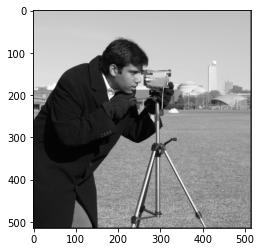

In [12]:
plt.imshow(p_x[0][0], cmap='gray')

In [13]:
# np.shape(padded_x[0:3, 0:3])

In [14]:
x_1 = p_x[0][0][0:3, 0:3]
# print(np.shape(x_1))
# print(x_1)

In [15]:
w_1 = w[0][0]
print(np.shape(w_1))
print(w_1)

(3, 3)
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


In [16]:
# w_1[0,1]

In [17]:
x_1 @ w_1 # np.dot(x_1, w_1)

array([[   0,    0,    0],
       [-200, -400, -200],
       [-199, -398, -199]])

In [18]:
x_1 * w_1 

array([[   0,    0,    0],
       [   0,    0,    0],
       [   0, -400, -199]])

In [19]:
H = W = 512
stride = 1
F_size = 3

In [20]:
# # dt = {}
# w_1 = w[1][0]
# print(np.shape(w_1))
# print(w_1)
# padded_x = np.pad(x.squeeze(), 1)
# result = None
# for i in range(0, H, stride):
#     row_res = None

#     for j in range(0, W, stride):
#         x_clip = padded_x[i:i+F_size, j:j+F_size]
#         a_ij = np.sum(x_clip * w_1.T)
#         # https://stats.stackexchange.com/questions/335321/in-a-convolutional-neural-network-cnn-when-convolving-the-image-is-the-opera
#         # dt[f"{i}_{j}"] = a_ij
#         if row_res is None:
#             row_res = [a_ij]
#         else:
#             row_res.append(a_ij)
    
#     if result is None:
#         result = np.array(row_res)
#     else:
#         result = np.vstack((result, row_res))

# print(np.shape(result))
# plt.imshow(result, cmap='gray')


In [21]:
def conv_fl(x, w, pad=1, stride=1):
    # https://stats.stackexchange.com/questions/335321/in-a-convolutional-neural-network-cnn-when-convolving-the-image-is-the-opera
    # x = (batch, c, h, w)
    # w = (num, c, h, w)
    
    padded_x = np.pad(x.squeeze(), pad)
    p_x = padded_x.reshape(1, 1, *np.shape(padded_x))
    
    f_num = np.shape(w)[0]
    f_out = np.shape(w)[1] # 1
    f_h = np.shape(w)[2]
    f_w = np.shape(w)[3]
    
    batch = np.shape(x)[0]
    x_c = np.shape(x)[1]
    x_h = np.shape(x)[2]
    x_w = np.shape(x)[3]
    
    result = None
    for batch_n in range(batch):
        batch_result = None
        for fn in range(f_num):
            a_m = None
            for i in range(0, H, stride):
                row = []
                for j in range(0, W, stride):
                    
                    c_sum_row = []
                    for ch in range(x_c): # we have only 1 channel here, should sum across RGB?
                        x_clip = p_x[batch_n][ch][i:i+F_size, j:j+F_size] # [0] only one channel here
                        a_ij = np.sum(x_clip.T * w[fn]) ### WHY T here?
                        row.append(a_ij)
                    c_sum_row.append(row)
                c_sum_row = np.sum(np.array(c_sum_row), axis=0)
                
                a_m = np.array(c_sum_row) if a_m is None else np.vstack((a_m, c_sum_row))
                
            batch_result = np.expand_dims(a_m, axis=0) if batch_result is None else np.concatenate((batch_result, np.expand_dims(a_m, axis=0)))    
        result = np.expand_dims(batch_result, axis=0) if result is None else np.concatenate((result, np.expand_dims(batch_result, axis=0)))
    return result

In [22]:
# Convolve the filter w with the tensor x, but this time using matrix multiplication. You can find
# the description on how to transform the convolution operation into matrix multiplication here 
# https://leonardoaraujosantos.gitbook.io/artificial-inteligence/machine_learning/deep_learning/convolution_layer/making_faster 
# This link also contains two function, im2col and col2im that you can use. Use a
# stride of 1 and zero-pad the image such that the spatial resolution of the image stays the same after the
# operation.

In [23]:
def im2col(x, hh, ww, stride):
    """
    Args:
      x: image matrix to be translated into columns, (C,H,W)
      hh: filter height
      ww: filter width
      stride: stride
    Returns:
      col: (new_h*new_w,hh*ww*C) matrix, each column is a cube that will convolve with a filter
            new_h = (H-hh) // stride + 1, new_w = (W-ww) // stride + 1
    """

    c,h,w = x.shape
    new_h = (h-hh) // stride + 1
    new_w = (w-ww) // stride + 1
    col = np.zeros([new_h*new_w,c*hh*ww])

    for i in range(new_h):
        for j in range(new_w):
            patch = x[...,i*stride:i*stride+hh,j*stride:j*stride+ww]
            col[i*new_w+j,:] = np.reshape(patch,-1)
    return col

def col2im(mul, h_prime, w_prime,C):
    """
      Args:
      mul: (h_prime*w_prime*w,F) matrix, each col should be reshaped to C*h_prime*w_prime when C>0, or h_prime*w_prime when C = 0
      h_prime: reshaped filter height
      w_prime: reshaped filter width
      C: reshaped filter channel, if 0, reshape the filter to 2D, Otherwise reshape it to 3D
    Returns:
      if C == 0: (F,h_prime,w_prime) matrix
      Otherwise: (F,C,h_prime,w_prime) matrix
    """
    F = mul.shape[1]
    if(C == 1):
        out = np.zeros([F,h_prime,w_prime])
        for i in range(F):
            col = mul[:,i]
            out[i,:,:] = np.reshape(col,(h_prime,w_prime))
    else:
        out = np.zeros([F,C,h_prime,w_prime])
        for i in range(F):
            col = mul[:,i]
            out[i,:,:] = np.reshape(col,(C,h_prime,w_prime))

    return out

In [24]:
# test_x = im2col(padded_x.reshape(1, 514, 514), 3, 3, 1)
# print(f"shape test_x: {np.shape(test_x)}")
# test_w = w_1.reshape((9,1), order='F')
# print(f"test_x: {test_w}")
# print(f"w_1: {w_1}")

# print(f"shape test_x: {np.shape(test_x)}")
# print(f"shape test_w: {np.shape(test_w)}")

# test_res = (test_x @ test_w)

# print(f"shape test_w: {np.shape(test_res)}")
# test_res_img = col2im(test_res, 512, 512, 1)
# print(f"shape test_res_img: {np.shape(test_res_img)}")
# plt.imshow(test_res_img[0])

In [25]:
def fast_conv(x, w, pad=1, stride=1):

    # x = (batch, c, h, w)
    # w = (num, c, h, w)
    
    padded_x = np.pad(x.squeeze(), pad)
    p_x = padded_x.reshape(1, 1, *np.shape(padded_x))
    
    f_num = np.shape(w)[0]
    f_out = np.shape(w)[1] # 1
    f_h = np.shape(w)[2]
    f_w = np.shape(w)[3]
    
    batch = np.shape(x)[0]
    x_c = np.shape(x)[1]
    x_h = np.shape(x)[2]
    x_w = np.shape(x)[3]
    
    result = None
    
    for batch_n in range(batch):
        for fn in range(f_num):
            x_col = im2col(p_x[batch_n], f_h, f_w, stride)
            w_col = w[fn].reshape((f_h * f_w, f_out), order='F')
            conv_col = x_col @ w_col
            conv_img = col2im(conv_col, x_h, x_w, x_c)
            if result is None:
                result = conv_img
            else:
                result = np.concatenate((result, conv_img))
    return result

In [26]:
convs_fc = fast_conv(x,w)

In [27]:
convs_fl = conv_fl(x,w)

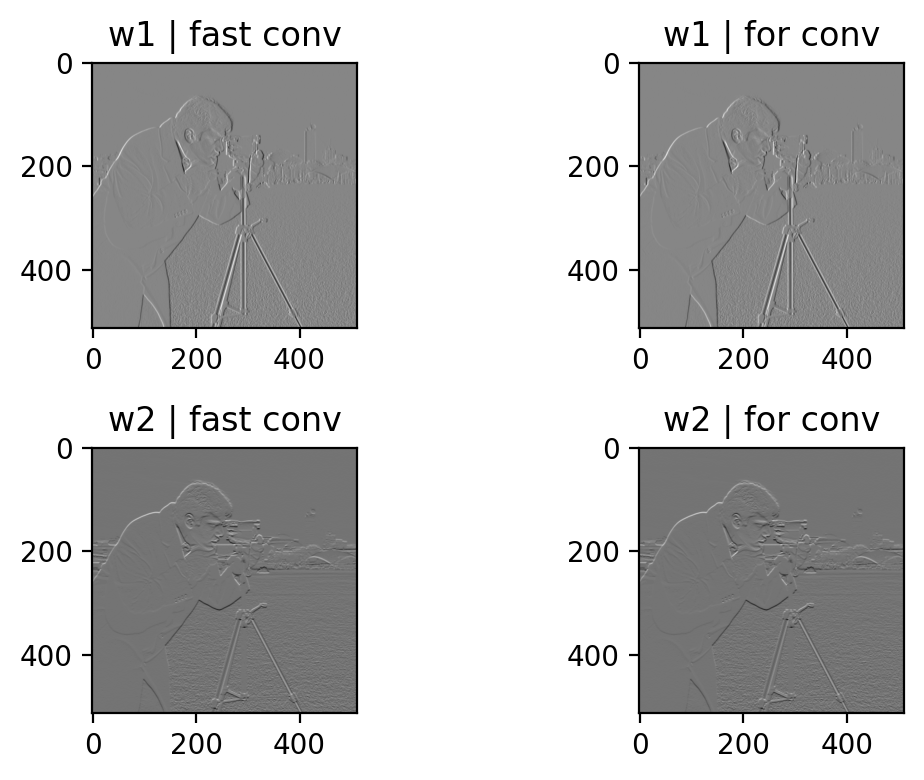

In [28]:
fig, axs = plt.subplots(2, 2, dpi=200)
axs[0, 0].imshow(convs_fc[0], cmap='gray')
axs[0, 0].set_title('w1 | fast conv')
axs[0, 1].imshow(convs_fl[0][0], cmap='gray')
axs[0, 1].set_title('w1 | for conv')
axs[1, 0].imshow(convs_fc[1], cmap='gray')
axs[1, 0].set_title('w2 | fast conv')
axs[1, 1].imshow(convs_fl[0][1], cmap='gray')
axs[1, 1].set_title('w2 | for conv')
fig.tight_layout()